## Time Series (TS) Modelling

TS is different from regular regression for

- It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.

- Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import math
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 200, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mp.style.use('ggplot')
sns.set(style='whitegrid')

In [72]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf 
from tbats import TBATS, BATS

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from xgboost import plot_importance, plot_tree
split_date = datetime.datetime(2019, 1, 1)

from utils import *

### 1. Load data

In [3]:
# the daily number of hired bikes 
col = [0,1]
bikes = pd.read_excel('input/tfl-daily-cycle-hires.xlsx', sheet_name = 'Data' , usecols = col, converters= {'Day': pd.to_datetime})

In [4]:
# generate features by day
bikes['month'] = bikes.Day.dt.to_period('M')
bikes['quarter'] = bikes.Day.dt.to_period('Q')
bikes['year'] = bikes.Day.dt.year
bikes['dayofweek'] = bikes.Day.dt.dayofweek
bikes['dayofyear'] = bikes.Day.dt.dayofyear
bikes['dayofmonth'] = bikes.Day.dt.day
bikes['weekofyear'] = bikes.Day.dt.weekofyear 
bikes['monthofyear'] = bikes.Day.dt.month 
bikes['quarterofyear'] = bikes.Day.dt.quarter 
bikes['is_Q2Q3'] = bikes.quarter.astype(str).str[4:].isin(['Q2','Q3'])
bikes.rename(columns={"Number of Bicycle Hires": "number"}, inplace = True)

In [5]:
# daily power usage
power = pd.read_csv('input/electrical_power_data.csv', parse_dates=['SD']) 
cols = power.columns.drop('SD')
power[cols] = power[cols].replace(',','', regex=True).apply(pd.to_numeric, errors='coerce')

In [6]:
# bank holiday
holidays = pd.read_csv('input/ukbankholidays.csv', names=['bank_hol'], parse_dates=['bank_hol'], header = 0)

In [7]:
data = bikes.merge(power, left_on='Day', right_on='SD', how = 'left')
data.drop(columns = 'SD', inplace = True)
data['is_bank_holiday'] = data['Day'].isin(holidays.bank_hol)

In [8]:
data.head()

,Day,number,month,quarter,year,dayofweek,dayofyear,dayofmonth,weekofyear,monthofyear,quarterofyear,is_Q2Q3,Gas,Coal,Nuclear,Hydro,Net Pumped,Wind,OCGT,Oil,Biomass,French Int,Dutch Int,NI Int,Eire Int,Nemo Int,Net Supply,is_bank_holiday
0,2010-07-30,6897,2010-07,2010Q3,2010,4,211,30,30,7,3,True,431920,184603,122467,4417,-4582,4841,15,0,0,44898,0,-7411,0,0,781168,False
1,2010-07-31,5564,2010-07,2010Q3,2010,5,212,31,30,7,3,True,406077,111091,121983,4604,726,7013,0,0,0,46443,0,-4932,0,0,693004,False
2,2010-08-01,4303,2010-08,2010Q3,2010,6,213,1,30,8,3,True,393442,109041,126746,4839,-6091,4264,0,0,0,47760,0,-5775,0,0,674225,False
3,2010-08-02,6642,2010-08,2010Q3,2010,0,214,2,31,8,3,True,429981,190693,122512,3638,-2698,866,0,0,0,45391,0,-7895,0,0,782488,False
4,2010-08-03,7966,2010-08,2010Q3,2010,1,215,3,31,8,3,True,433955,182201,125603,3594,-4137,5358,4,0,0,45788,0,-7593,0,0,784771,False


### 2. Data Exploration

#### 2.1 Target Variables - number of rented bikes in every day

In [9]:
ts_data = data[['Day', 'number']].set_index('Day')

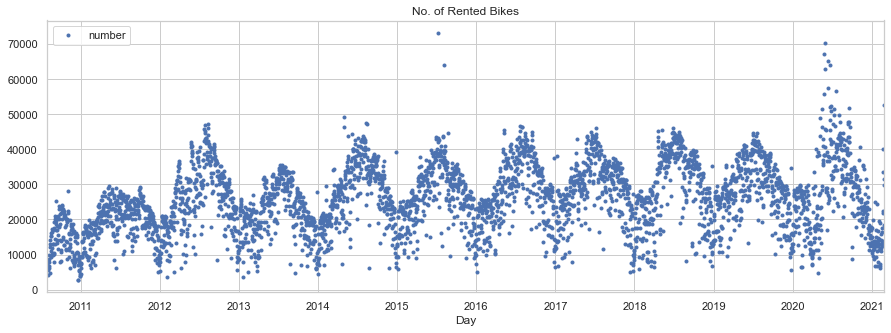

In [10]:
# daily 
ts_data.plot(figsize=(15,5), title='No. of Rented Bikes', style='.')
plt.show()

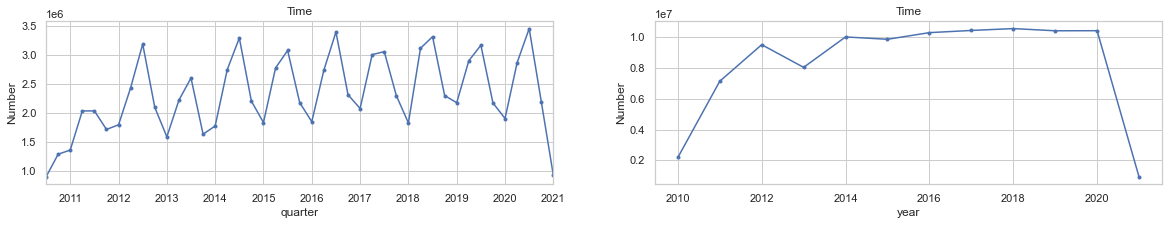

In [11]:
# aggregated
tmp1 = data.groupby('month').number.sum()
tmp2 = data.groupby('quarter').number.sum()
tmp3 = data.groupby('year').number.sum()

f,ax=plt.subplots(1,2,figsize=(20,3))
tmp2.plot(style='.-', ax=ax[0])
ax[0].set_title('Time')
ax[0].set_ylabel('Number')

tmp3.plot(style='.-', ax=ax[1])
ax[1].set_title('Time')
ax[1].set_ylabel('Number')

plt.show()

#### Testing stationarity

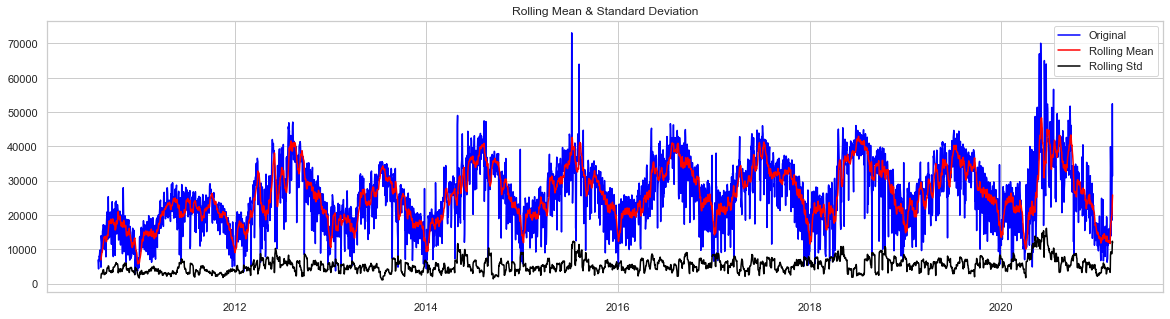

Results of Dickey-Fuller Test:
Test Statistic                   -4.043076
p-value                           0.001201
#Lags Used                       29.000000
Number of Observations Used    3837.000000
Critical Value (1%)              -3.432055
Critical Value (5%)              -2.862294
Critical Value (10%)             -2.567171
dtype: float64


In [12]:
test_stationarity(ts_data)

- Though the variation in standard deviation is small, mean is clearly changing with time. 
- the [Dickey–Fuller test](https://en.wikipedia.org/wiki/Dickey–Fuller_test) tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.
- The TS is trend stationary but seasonality has been detected


**Reasons behind non-stationaruty of a TS**
- Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
- Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

**Process of TS**
- Model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series.
- Then statistical forecasting techniques can be implemented on this series. 
- Convert the forecasted values into the original scale by applying trend and seasonality constraints back.

**Trend**
- Transformation: log
- Aggregation: taking average for a time period like monthly/weekly averages
- Smoothing: Moving Average/ Exponentially Weighted Moving Average
- Polynomial Fitting: fit a regression model

**Seasonality**
- Differencing: taking the differece with a particular time lag (work for both trend and Seasonality)
- Decomposition: modeling both trend and seasonality and removing them from the data

In [13]:
ts_data_diff = difference(ts_data, interval=365)

In [14]:
dti = pd.date_range(ts_data.index[0] + datetime.timedelta(days=365), 
                    periods=ts_data_diff.shape[0], 
                    freq="D",
                    name = 'Day')
ts_data_diff = ts_data_diff.rename(columns = {0: 'number'}).set_index(dti)

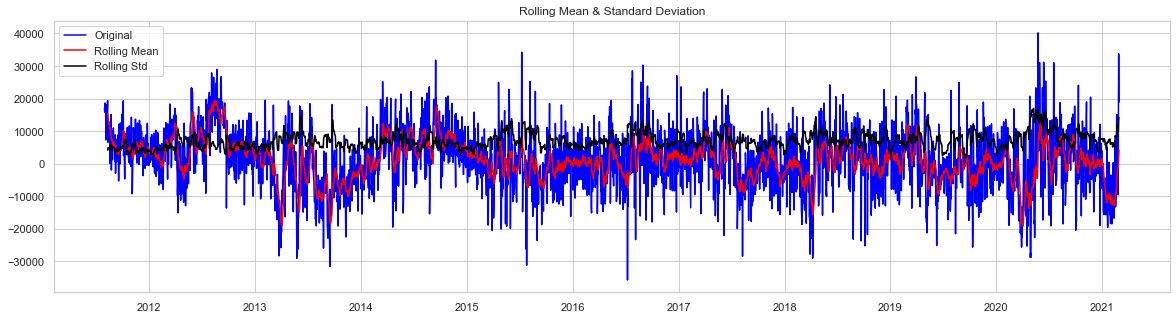

Results of Dickey-Fuller Test:
Test Statistic                -6.007038e+00
p-value                        1.606322e-07
#Lags Used                     3.000000e+01
Number of Observations Used    3.471000e+03
Critical Value (1%)           -3.432235e+00
Critical Value (5%)           -2.862373e+00
Critical Value (10%)          -2.567213e+00
dtype: float64


In [15]:
test_stationarity(ts_data_diff)

- Even we take the difference of 365, the seasonality is still displaied. 

#### 2.2 Correlation Check
- Correlation is a measure of the linear relationship of 2 or more variables. Through correlation, we can predict one variable from the other. 
- The logic behind using correlation for feature selection is that the good variables are highly correlated with the target.
- A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.
- We will use Pearson's correlation. It is utilized we you have two quantitative variables and you wish to see if there is a linear relationship between those variables.

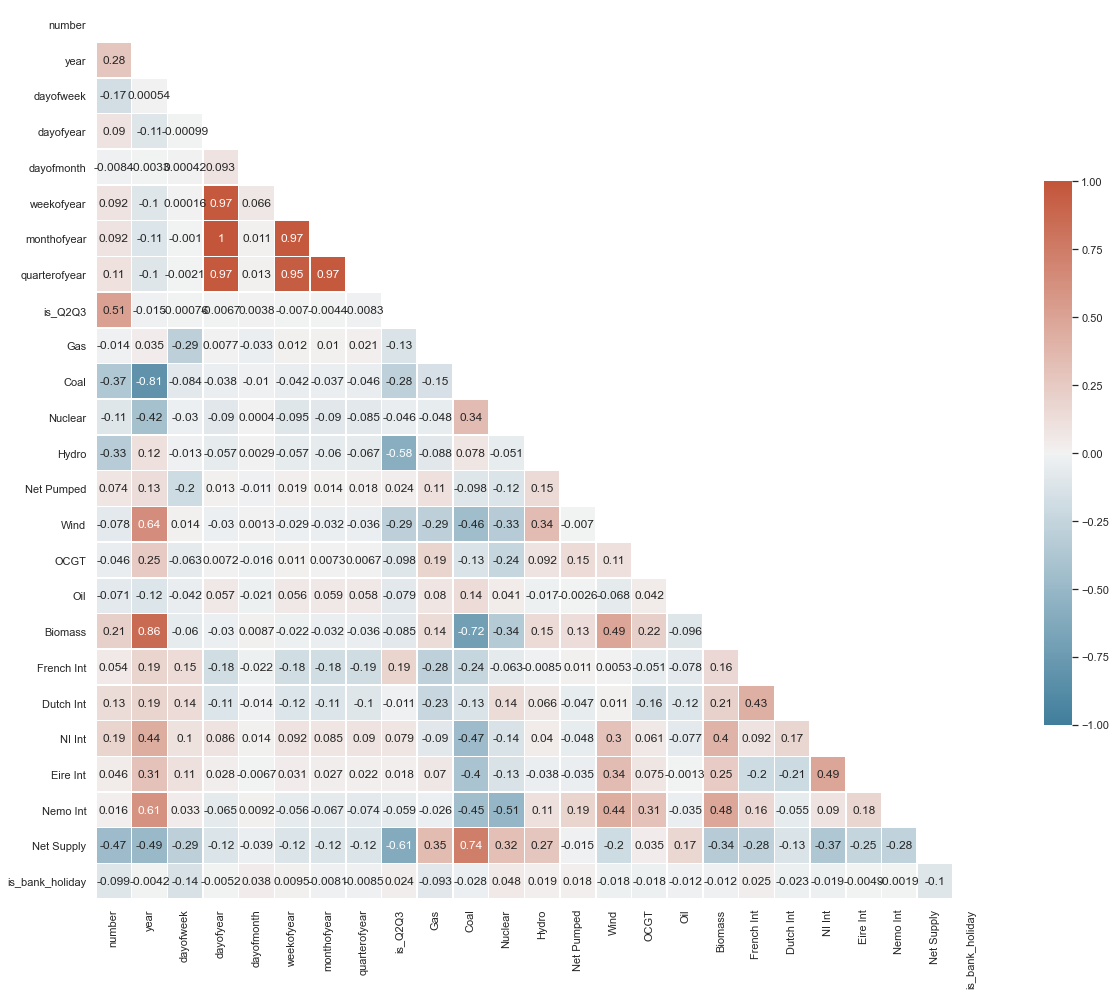

In [17]:
train_corr = data.corr(method= 'pearson') # Compute pairwise correlation of columns, excluding NA/null values. pearson : standard correlation coefficient
f, ax = plt.subplots(figsize=(20, 20))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(train_corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

ax = sns.heatmap(train_corr, vmin=-1, vmax=1, mask=mask, cmap=cmap, center=0, annot = True, square=True, linewidths=.5, cbar_kws= {"shrink": .5, 'orientation': 'vertical'}) 

In above correlation map,

- -1 indicates a perfectly negative linear correlation between two variables.
- 0 indicates no linear correlation between two variables.
- 1 indicates a perfectly positive linear correlation between two variables.

Features correlated with number are is_Q2Q3 (0.51), net_supply (-0.47)

#### 2.3 Multicollinearity Analysis
Multicollinearity refers to a situation in which more than two explanatory variables in a multiple regression model are highly linearly related. Below are few of the multicollinear features based on correlation matrix.

Features correlated with coal are Net supply(0.74), Bipmass(-0.72), TotalBsmtSF(0.54), wind (-0.46), Nemo int(-0.45)

Note: Correlation is only an indication of presence of multicollinearity, removing features only on the basis of the correlation can lead to a loosing valuable information.

- The best way to identify the multicollinearity is to calculate the Variance Inflation Factor (VIF) for every feature in the Dataset. 
- Other way is to use regression techniques like Ridge or Lasso, in these models we use extra lambda value which penalizes some of the coefficients for particular columns which in turn reduces the effect of multicollinearity.
- or use tree based methods, decision trees are by nature immune to multi-collinearity

#### 2.4 Variable Visulization

#### character features

In [18]:
cols = ['quarterofyear', 'is_Q2Q3', 'is_bank_holiday', 'dayofweek']
for i in range(len(cols)):
    plot_character(data, cols[i], 'number', i)

#### numerical features

In [21]:
cols = data.columns[12:27]
for i in range(len(cols)):
    plot_numeric(data, cols[i], 'number', i)

#### 2.5 Outliers Check
- We will use minimum and maximum threshold to remove the outliers from all the numeric features in training data.
- We might delete every record less than min threshold and more than max threshold.
- No processing here

In [22]:
def scatterplot(df, feature, target):
    plt.scatter(x=df[feature], y=df[target], color=('yellowgreen'), alpha=0.5)
    plt.axvline(x=df[feature].quantile(0.99), color='r', linestyle='-')
    plt.axvline(x=df[feature].quantile(0.01), color='r', linestyle='-')
    plt.title('{} - Rented Bikes scatter plot'.format(feature), fontsize=15, weight='bold' )

In [23]:
cols = data.columns[12:27]
fig = plt.figure(figsize=(25,15))
ax1 = plt.subplot2grid((3,5),(0,0)), scatterplot(data, cols[0], 'number')
ax1 = plt.subplot2grid((3,5),(0,1)), scatterplot(data, cols[1], 'number')
ax1 = plt.subplot2grid((3,5),(0,2)), scatterplot(data, cols[2], 'number')
ax1 = plt.subplot2grid((3,5),(0,3)), scatterplot(data, cols[3], 'number')
ax1 = plt.subplot2grid((3,5),(0,4)), scatterplot(data, cols[4], 'number')
ax1 = plt.subplot2grid((3,5),(1,0)), scatterplot(data, cols[5], 'number')
ax1 = plt.subplot2grid((3,5),(1,1)), scatterplot(data, cols[6], 'number')
ax1 = plt.subplot2grid((3,5),(1,2)), scatterplot(data, cols[7], 'number')
ax1 = plt.subplot2grid((3,5),(1,3)), scatterplot(data, cols[8], 'number')
ax1 = plt.subplot2grid((3,5),(1,4)), scatterplot(data, cols[9], 'number')
ax1 = plt.subplot2grid((3,5),(2,0)), scatterplot(data, cols[10], 'number')
ax1 = plt.subplot2grid((3,5),(2,1)), scatterplot(data, cols[11], 'number')
ax1 = plt.subplot2grid((3,5),(2,2)), scatterplot(data, cols[12], 'number')
ax1 = plt.subplot2grid((3,5),(2,3)), scatterplot(data, cols[13], 'number')
ax1 = plt.subplot2grid((3,5),(2,4)), scatterplot(data, cols[14], 'number')
fig.savefig("plots/outlier.png")
plt.close()

#### 2.6 Check Mising Values

In [24]:
# Get the list of column that have null values
data.columns[data.isnull().any()]

Index([], dtype='object')

### 3. Feature Engineering

#### 3.1 Encoding categorical variables

In [25]:
cols = ['is_Q2Q3', 'is_bank_holiday']
data[cols] = data[cols].apply(np.uint8)

### 4. Modelling

**Evaluation metric**

- root of mean square error 
- mean of absolute error
- mean absolute percentage error

#### 4.1 Model with TFL data only (ARIMA)

- statsmodels
- tbats


In [26]:
tfl_train = data[data.Day <= split_date].iloc[:, :2].copy()
tfl_test = data[data.Day > split_date].iloc[:, :2].copy()

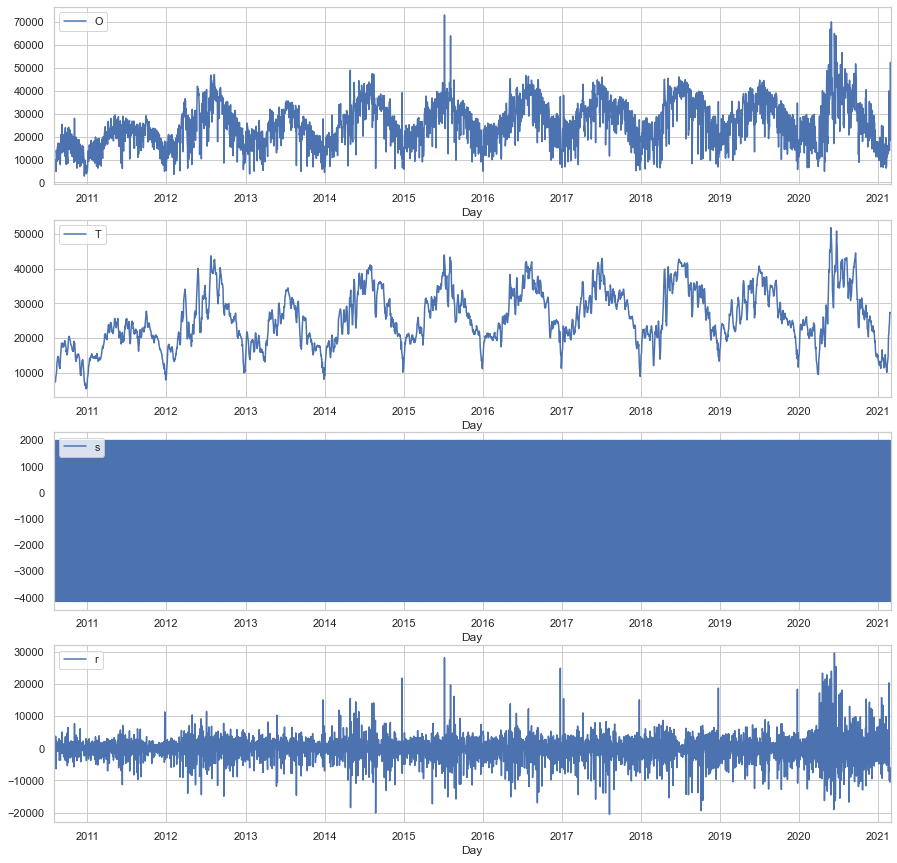

In [29]:
decomposition = seasonal_decompose(ts_data)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, ax = plt.subplots(4,1,figsize=(15,15))

ts_data.plot(style='-', ax=ax[0])
ax[0].legend('Original', loc=2)

trend.plot(style='-', ax=ax[1])
ax[1].legend('Trend', loc=2)

seasonal.plot(style='-', ax=ax[2])
ax[2].legend('seasonal', loc=2)

residual.plot(style='-', ax=ax[3])
ax[3].legend('residual', loc=2)


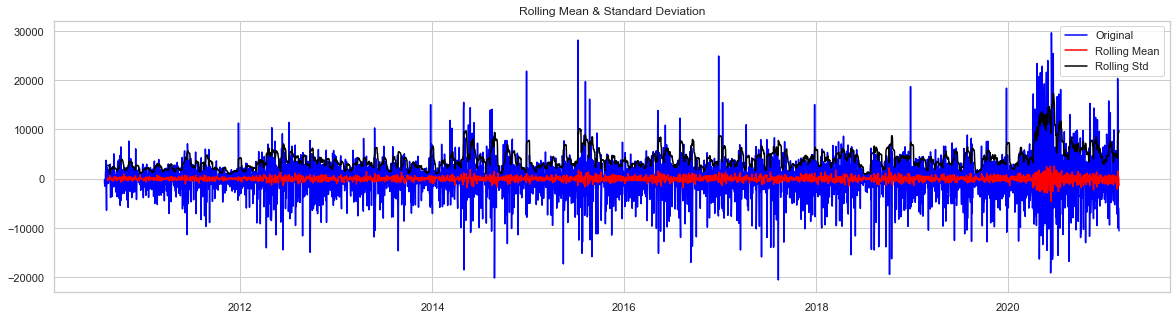

Results of Dickey-Fuller Test:
Test Statistic                  -23.074203
p-value                           0.000000
#Lags Used                       29.000000
Number of Observations Used    3831.000000
Critical Value (1%)              -3.432058
Critical Value (5%)              -2.862295
Critical Value (10%)             -2.567172
dtype: float64


In [30]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

In [33]:
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit(tfl_train.set_index('Day'))

In [34]:
# y in time
y_in_time = model.y_hat

# Forecast 365 days ahead
y_forecast = model.forecast(steps=tfl_test.shape[0])

In [35]:
# Time series analysis
# print(model.resid) # in sample residuals
# print(model.aic)

# Reading model parameters
print(model.params.alpha)
print(model.params.beta)
# print(model.params.x0)
# print(model.params.components.use_box_cox)
print(model.params.components.seasonal_harmonics)

0.27320894953103536
-0.044527713011657914
[3 9]


In [36]:
dti1 = pd.date_range(ts_data.index[0], 
                    split_date, 
                    freq="D",
                    name = 'Day')
y_in_time = pd.DataFrame(y_in_time).rename(columns={0: 'Train Set'}).set_index(dti1)

dti2 = pd.date_range(split_date + datetime.timedelta(days=1), 
                    periods = tfl_test.shape[0], 
                    freq="D",
                    name = 'Day')

y_forecast = pd.DataFrame(y_forecast).rename(columns={0: 'Test Set'}).set_index(dti2)
y_predict = y_in_time.join(y_forecast, how='outer')

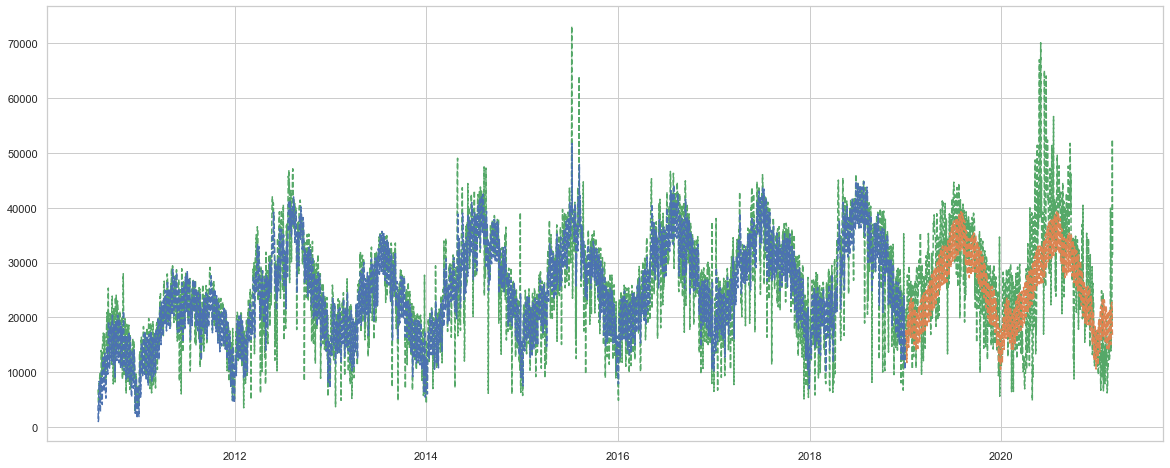

In [37]:
fig, ax = plt.subplots(1,1, figsize= (20,8))
plt.plot(ts_data.index, ts_data, 'g', linestyle='dashed') # plotting t, b separately 
plt.plot(y_predict.index, y_predict, linestyle='dashed') # plotting t, a separately 
plt.show()

In [42]:
# training error
print(rmse(y_true=tfl_train['number'], y_pred=y_in_time['Train Set']))
print(mae(y_true=tfl_train['number'], y_pred=y_in_time['Train Set']))
print(mean_absolute_percentage_error(y_true=tfl_train['number'], y_pred=y_in_time['Train Set']))

4715.514029528106
3324.0718468254145
17.247226643738305


In [43]:
# out-of-time error
print(rmse(y_true=tfl_test['number'], y_pred=y_forecast['Test Set']))
print(mae(y_true=tfl_test['number'], y_pred=y_forecast['Test Set']))
print(mean_absolute_percentage_error(y_true=tfl_test['number'], y_pred=y_forecast['Test Set']))

8120.806644550601
5932.62806889301
27.27895401287221


#### 4.2 Model with TFL data only (Prophet)

- Apply time series model using Prophet by Facebook
- Prophet predict time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

In [44]:
tfl_train = data[data.Day <= split_date].iloc[:, :2].copy()
tfl_test = data[data.Day > split_date].iloc[:, :2].copy()

In [45]:
tfl_train.shape,tfl_test.shape, tfl_test.shape[0]/(tfl_test.shape[0] + tfl_train.shape[0])

((3078, 2), (789, 2), 0.20403413498836306)

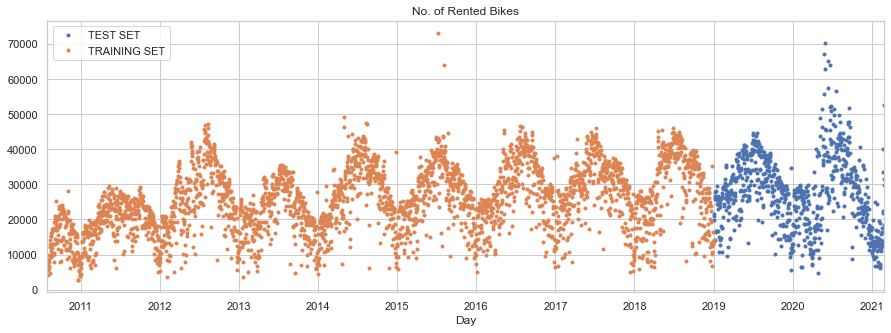

In [46]:
# Plot train and test so you can see where we have split
tfl_test.set_index('Day').rename(columns={'number': 'TEST SET'}) \
    .join(tfl_train.set_index('Day').rename(columns={'number': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='No. of Rented Bikes', style='.')
plt.show()

In [47]:
# Format data for prophet model using ds and y
tfl_train.rename(columns={'Day':'ds','number':'y'}).head(2)

,ds,y
0,2010-07-30,6897
1,2010-07-31,5564


In [48]:
# Setup and train model and fit
model_ts = Prophet()
model_ts.fit(tfl_train.rename(columns={'Day':'ds','number':'y'}))
tfl_train_fcst = model_ts.predict(df=tfl_train.rename(columns={'Day':'ds','number':'y'}))
tfl_test_fcst = model_ts.predict(df=tfl_test.rename(columns={'Day':'ds','number':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


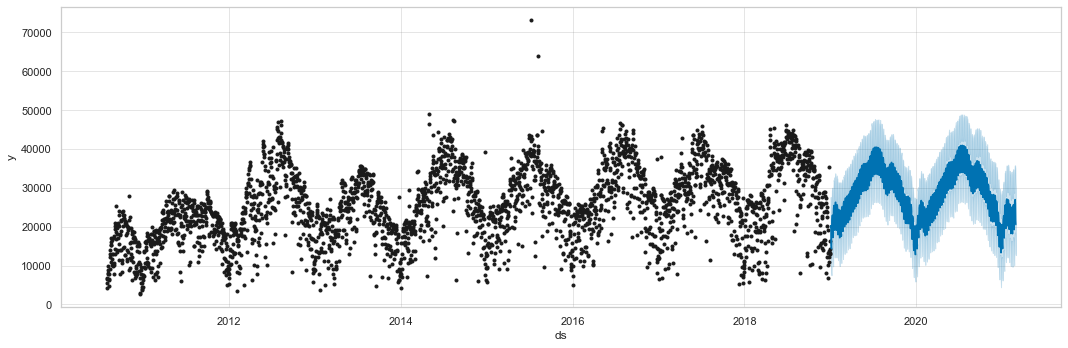

In [49]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_ts.plot(tfl_test_fcst,ax=ax)
plt.show()

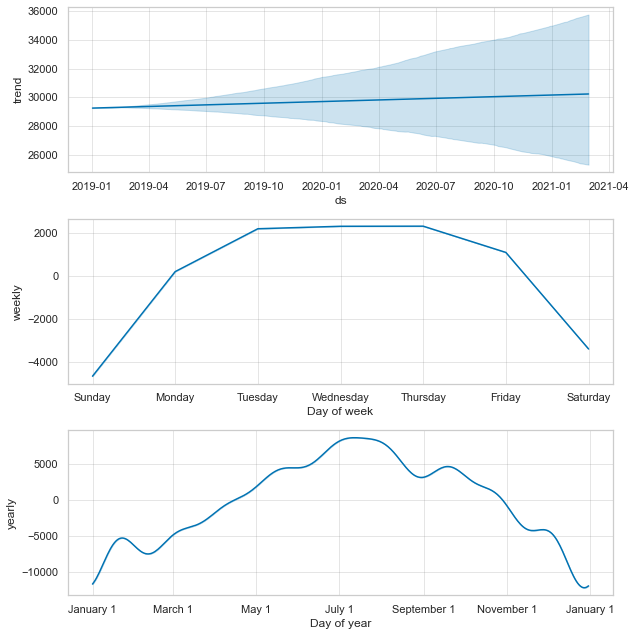

In [50]:
# Plot the components of the model
fig = model_ts.plot_components(tfl_test_fcst)

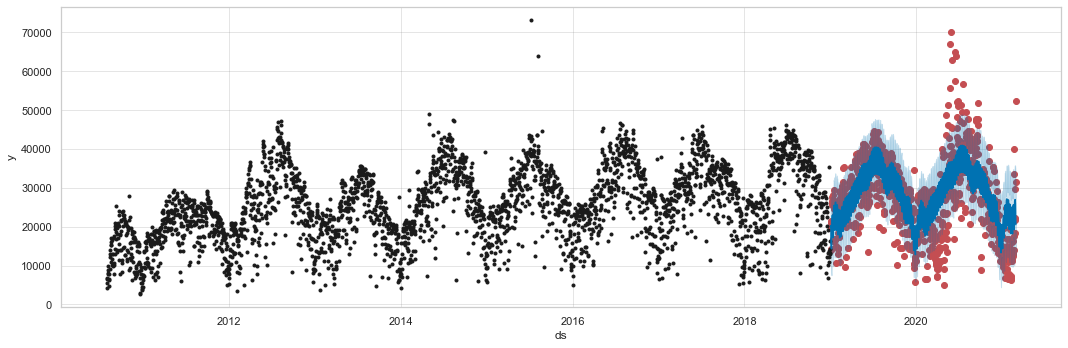

In [51]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(tfl_test.Day, tfl_test['number'], color='r')
fig = model_ts.plot(tfl_test_fcst,ax=ax)

In [52]:
## cross validation error - rmse 
df_cv = cross_validation(model_ts, horizon = '720 days')
df_p = performance_metrics(df_cv)
df_p.rmse.mean()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-01-11 00:00:00 and 2017-01-11 00:00:00


6204.51536749155

In [53]:
# training error
print(rmse(y_true=tfl_train['number'], y_pred=tfl_train_fcst['yhat']))
print(mae(y_true=tfl_train['number'], y_pred=tfl_train_fcst['yhat']))
print(mean_absolute_percentage_error(y_true=tfl_train['number'], y_pred=tfl_train_fcst['yhat']))

5456.4986045440055
4022.142560663144
21.187559335767023


In [54]:
# out-of-tiime error
print(rmse(y_true=tfl_test['number'], y_pred=tfl_test_fcst['yhat']))
print(mae(y_true=tfl_test['number'], y_pred=tfl_test_fcst['yhat']))
print(mean_absolute_percentage_error(y_true=tfl_test['number'], y_pred=tfl_test_fcst['yhat']))

8294.304563063573
5987.22417239234
31.151542052370807


#### 4.3 Model with TFL and electrical power generation dataset

From the correlation plots, multicollinearity can be detected, therefore we use ensembling methods with decision trees, as decision trees are by nature immune to multi-collinearity. 

- XGboost
- LightGBM

In [55]:
ids = [1] + list(range(5, 28))
cols = data.columns[ids]
cols

Index(['number', 'dayofweek', 'dayofyear', 'dayofmonth', 'weekofyear',
       'monthofyear', 'quarterofyear', 'is_Q2Q3', 'Gas', 'Coal', 'Nuclear',
       'Hydro', 'Net Pumped', 'Wind', 'OCGT', 'Oil', 'Biomass', 'French Int',
       'Dutch Int', 'NI Int', 'Eire Int', 'Nemo Int', 'Net Supply',
       'is_bank_holiday'],
      dtype='object')

In [56]:
train = data[data.Day <= split_date][cols].copy()
test = data[data.Day > split_date][cols].copy()

In [57]:
X_train = train.loc[:, test.columns != 'number']
y_train = train.number
X_test = test.loc[:, test.columns != 'number']
y_test = test.number

**XGboost**

In [58]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state =7, nthread = -1)

model_xgb.fit(X_train, 
        y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, subsample=0.5213, tree_method='exact',
             validate_parameters=1, verbosity=None)

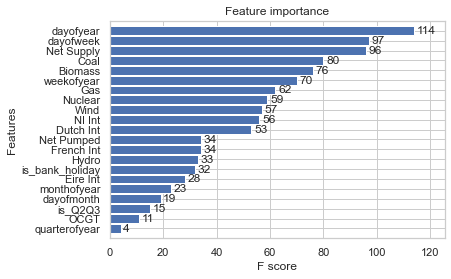

In [59]:
_ = plot_importance(model_xgb, height=0.9)

In [60]:
test['y_pred'] = model_xgb.predict(X_test) 
all_data = pd.concat([test, train], sort=False)

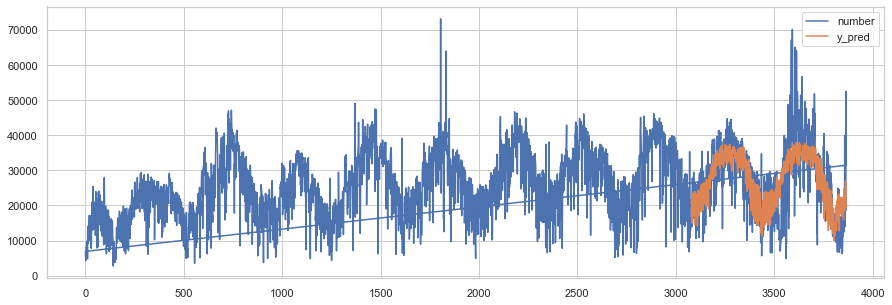

In [61]:
_ = all_data[['number','y_pred']].plot(figsize=(15, 5))

In [62]:
# cross validation error - rmse
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Xgboost score: 4577.2709 (106.5463)



In [63]:
# out of time error
print(rmse(y_true=test['number'], y_pred=test['y_pred']))
print(mae(y_true=test['number'], y_pred=test['y_pred']))
print(mean_absolute_percentage_error(y_true=test['number'], y_pred=test['y_pred']))

7891.258743099767
5777.160210709759
27.90598131423147


**Light GBM**

In [64]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [65]:
model_lgb.fit(X_train, 
              y_train, 
              eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=50,
              verbose=False) 

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')

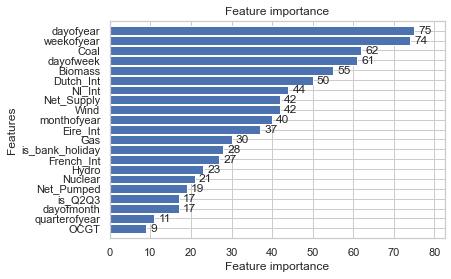

In [66]:
_ = lgb.plot_importance(model_lgb, height=0.9)

In [67]:
test['y_pred'] = model_lgb.predict(X_test) 
all_data = pd.concat([test, train], sort=False)

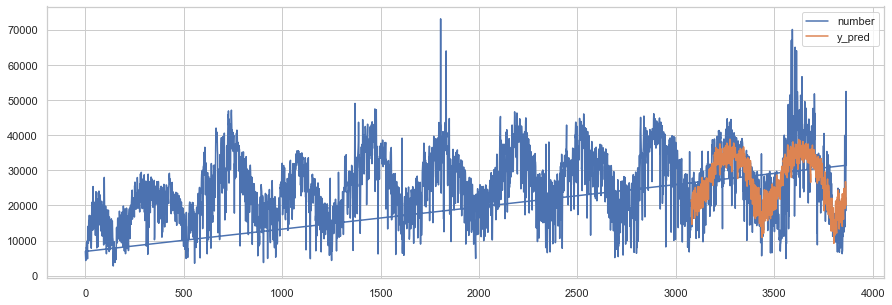

In [68]:
_ = all_data[['number','y_pred']].plot(figsize=(15, 5))

In [69]:
# cross validation error - rmse
score = rmsle_cv(model_lgb)
print("LGB score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGB score: 4746.8101 (77.4142)



In [70]:
# out of time error
print(rmse(y_true=test['number'], y_pred=test['y_pred']))
print(mae(y_true=test['number'], y_pred=test['y_pred']))
print(mean_absolute_percentage_error(y_true=test['number'], y_pred=test['y_pred']))

7982.275773896556
5848.0683253686875
28.560227786958343


### 5. Conclusion 
- Compare to the Prophet model with TFL data only, Xgboost and Lightgbm which includes both tfl data and energy consumtion data give better accuracy - lower rmse,mae, mape in out-of-time sample
- RMSE in training sample with cross validation is lower than out-of-time sample, which might be due to the abnormal peak after 2020
- From the correlattion plot and feature importantance plot given by Xgboost and lightgbm, energy consumption features show predicting power in number of rented cars, like - net supply, coal, biomass